In [1]:
import pandas as pd
import os

In [2]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms as T
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
print(torch.cuda.is_available())

True


In [4]:
df_train = pd.read_csv('competition_train.csv')
df_train = df_train.loc[~df_train['BoxesString'].str.contains('no_box'),:].reset_index(drop=True)
df_val = pd.read_csv('competition_val.csv')
df_val = df_val.loc[~df_val['BoxesString'].str.contains('no_box'),:].reset_index(drop=True)
df_test = pd.read_csv('competition_test.csv')
df_test = df_test.loc[~df_test['BoxesString'].str.contains('no_box'),:].reset_index(drop=True)
print(df_train)

                                             image_name  \
0     4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...   
1     a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...   
2     401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...   
3     0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...   
4     be1652110a44acd24b42784356e965ce84a04893c3f1bb...   
...                                                 ...   
3602  aa8967fdf620ab4d7b6ff75531ad37cf16a5f5deca131d...   
3603  4bfbbdac0fd5c16db471aa3dcfa20e6b2bbd60230b1969...   
3604  cd4a7c09f3b6832278f24d30b9143718dfde8998f2da78...   
3605  3362115207dbd2b1e28cb22b14eb910a0cb1068c7e47b7...   
3606  de85de89b3969fc6eb97d0c83299ad725a52595bde4533...   

                                            BoxesString          domain  
0     99 692 160 764;641 27 697 115;935 978 1012 102...       Arvalis_1  
1     230 143 321 222;928 929 1015 1004;485 557 604 ...       Arvalis_1  
2     440 239 544 288;333 538 429 594;913 171 963 20...       Arvalis

In [5]:
def convert_boxes_string_to_list(boxes_string):
    groups = boxes_string.split(";")
    result = []
    for group in groups:
        nums = group.split()
        # Filtrar valores que no son números
        nums = [int(num) for num in nums if num.isdigit()]
        result.append(nums)
    return result

# Aplica la función a la columna 'BoxesString'
df_test['BoxesString'] = df_test['BoxesString'].apply(convert_boxes_string_to_list)
df_train['BoxesString'] = df_train['BoxesString'].apply(convert_boxes_string_to_list)
df_val['BoxesString'] = df_val['BoxesString'].apply(convert_boxes_string_to_list)

print(df_train.head())



                                          image_name  \
0  4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...   
1  a2a15938845d9812de03bd44799c4b1bf856a8ad11752e...   
2  401f89a2bb6ab63e3f406bd59b9cadccfe953230feb6cd...   
3  0a3937653483c36dfb4d957b6f82ae96dbdc7ba36cc3d8...   
4  be1652110a44acd24b42784356e965ce84a04893c3f1bb...   

                                         BoxesString     domain  
0  [[99, 692, 160, 764], [641, 27, 697, 115], [93...  Arvalis_1  
1  [[230, 143, 321, 222], [928, 929, 1015, 1004],...  Arvalis_1  
2  [[440, 239, 544, 288], [333, 538, 429, 594], [...  Arvalis_1  
3  [[112, 274, 188, 303], [892, 812, 958, 847], [...  Arvalis_1  
4  [[810, 204, 863, 314], [360, 231, 425, 408], [...  Arvalis_1  


In [6]:
class ImageDataset(Dataset):
    def __init__(self, df, root_dir):
        self.df = df
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = T.ToTensor()(Image.open(img_name).convert("RGB"))/255
        boxes = self.df.iloc[idx, 1]
        num_objs = len(boxes)
        boxes = torch.tensor(boxes, dtype=torch.float32)

        labels = torch.ones((len(boxes),), dtype=torch.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": iscrowd
        }

        return image, target

    def print_image(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        draw = ImageDraw.Draw(image)
        boxes = self.df.iloc[idx, 1]
        for box in boxes:
            draw.rectangle(box, outline="red", width=4)
        plt.imshow(image)
        plt.show()

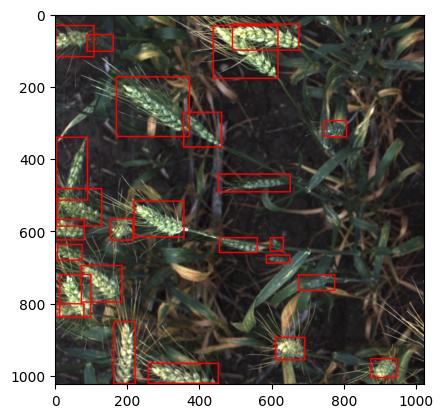

In [7]:
dataset_train = ImageDataset(df_train, 'images')
dataset_val = ImageDataset(df_val, 'images')
dataset_test = ImageDataset(df_test, 'images')

dataset_val.print_image(0)

In [8]:
model = fasterrcnn_resnet50_fpn(progress=True, pretrained_backbone=True, num_classes=2, box_detections_per_img=200)
model.to(device)



optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets

data_loader_train = DataLoader(dataset_train, batch_size=8, collate_fn=collate_fn, shuffle=True)
len(data_loader_train)

c:\Users\jbote\Desktop\crag\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\Users\jbote\Desktop\crag\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


451

In [9]:
class EarlyStopping:
    def __init__(self, patience):
        self.best = 10
        self.count = 0
        self.patience = patience

    def earlyStopping(self, num):
        if num <= self.best:
            self.best = num
            self.count = 0
        else:
            self.count += 1
        if self.count >= self.patience:
            return self.best
        return None

In [10]:
model.train()
early_stopping = EarlyStopping(3)

losses_dict = {'loss_classifier': [], 'loss_box_reg': [], 'loss_objectness': [], 'loss_rpn_box_reg': [], 'total_loss': []}
stop_training = False

for epoch in tqdm(range(10), desc='epochs', colour='green'):
    if stop_training: 
        break
    
    losses_avg = {'loss_classifier': [], 'loss_box_reg': [], 'loss_objectness': [], 'loss_rpn_box_reg': [], 'total_loss': []}

    for images, targets in tqdm(data_loader_train, desc='dataloader', colour='blue'):
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        loss_dict = model(images, targets)
        losses_avg['loss_classifier'].append(loss_dict['loss_classifier'].item())
        losses_avg['loss_box_reg'].append(loss_dict['loss_box_reg'].item())
        losses_avg['loss_objectness'].append(loss_dict['loss_objectness'].item())
        losses_avg['loss_rpn_box_reg'].append(loss_dict['loss_rpn_box_reg'].item())
        losses = sum(loss for loss in loss_dict.values())
        losses_avg['total_loss'].append(losses.item())



        # for loss in losses_dict['total_loss']:
        #     best = early_stopping.earlyStopping(loss)
        #     if best is not None:
        #         stop_training = True 
        #         break
        # if best is None:  
        #     best = early_stopping.best
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()  
    losses_dict['loss_classifier'].append(sum(losses_avg['loss_classifier'])/len(losses_avg['loss_classifier']))
    losses_dict['loss_box_reg'].append(sum(losses_avg['loss_box_reg'])/len(losses_avg['loss_box_reg']))
    losses_dict['loss_objectness'].append(sum(losses_avg['loss_objectness'])/len(losses_avg['loss_objectness']))
    losses_dict['loss_rpn_box_reg'].append(sum(losses_avg['loss_rpn_box_reg'])/len(losses_avg['loss_rpn_box_reg']))
    losses_dict['total_loss'].append(sum(losses_avg['total_loss'])/len(losses_avg['total_loss']))
    print(f"Epoch {epoch + 1}, loss_classifier: {losses_dict['loss_classifier']}\n loss_box_reg: {losses_dict['loss_box_reg']}\n loss_objectness: {losses_dict['loss_objectness']}\n loss_rpn_box_reg: {losses_dict['loss_rpn_box_reg']}\n total_loss: {losses_dict['total_loss']}")

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.7160, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(102.4970, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1921, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.3593, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.1839, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16.0447, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.1602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.1874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.5998, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4286, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1286, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2777, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0751, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8864, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1829, device='cuda:0', grad_fn=<A

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.6260, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7444, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4523, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5404, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5538, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7203, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6223, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5775, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6903, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5687, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5072, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3699, device='cuda:0', grad_fn=<AddBack

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.3512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5437, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5709, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6557, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5942, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4376, device='cuda:0', grad_fn=<AddBack

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.5478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4509, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7912, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7533, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5569, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5410, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5826, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5632, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5724, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6552, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5409, device='cuda:0', grad_fn=<AddBack

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.4360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5920, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7068, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7101, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3517, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7102, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6400, device='cuda:0', grad_fn=<AddBack

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.6870, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5863, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4845, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6200, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8365, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5172, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7317, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6228, device='cuda:0', grad_fn=<AddBack

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.7855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7118, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7970, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8153, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8368, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8309, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6622, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8221, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8806, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8565, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8560, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8600, device='cuda:0', grad_fn=<AddBack

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(1.6403, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5645, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6596, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7780, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7723, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6687, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6984, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6114, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6876, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5235, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5205, device='cuda:0', grad_fn=<AddBack

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(182.7429, device='cuda:0', grad_fn=<AddBackward0>)
tensor(236.8945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.0920, device='cuda:0', grad_fn=<AddBackward0>)
tensor(206.2495, device='cuda:0', grad_fn=<AddBackward0>)
tensor(195.2329, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2579.8501, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58.6124, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4876.0171, device='cuda:0', grad_fn=<AddBackward0>)
tensor(279.4032, device='cuda:0', grad_fn=<AddBackward0>)
tensor(88.9732, device='cuda:0', grad_fn=<AddBackward0>)
tensor(82.6506, device='cuda:0', grad_fn=<AddBackward0>)
tensor(105.3669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(130.5551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1286.9811, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14896.1270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(223.1625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(307.6021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1462.5

dataloader:   0%|          | 0/451 [00:00<?, ?it/s]

tensor(297042.7500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(416680.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1649276.7500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(157642.7188, device='cuda:0', grad_fn=<AddBackward0>)
tensor(139028.8906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(156215.7812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(69905.8672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(193904.5469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(64605.8633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28303.6992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22932.0605, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17552.2148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33077.4258, device='cuda:0', grad_fn=<AddBackward0>)
tensor(622350.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(83123.8516, device='cuda:0', grad_fn=<AddBackward0>)
tensor(88473.1328, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1132053.2500, device='cu